# IMPORT BASIC TOOLS

In [1]:
import numpy as np
import pandas as pd

# IMPORT DATA, INSPECT

In [32]:
data = pd.read_csv('http://localhost:8888/files/sfdat28-burkart-project-2/diabetes.csv')

# CONVENTIONALIZE COLUMN NAMES  & DROP PATIENT-IDENTIFYING INFO

In [33]:
data.columns = [each.replace(' ','_').lower() for each in data.columns]
data.columns = [each.replace('-','_').lower() for each in data.columns]

data = data.rename(columns = {'admission_type_id' : 'admission_type',
                              'discharge_disposition_id' : 'discharge_disposition',
                              'admission_source_id' : 'admission_source',
                              'time_in_hospital' : 'days_in_hospital',
                              'payer_code' : 'payor_code',
                              'medical_specialty' : 'referring_specialty', 
                              'num_lab_procedures' : 'number_labs',
                              'num_procedures' : 'number_procedures', 
                              'num_medications' : 'number_meds',
                              'number_diagnoses' : 'total_number_diag', 
                              'max_glu_serum' : 'max_blood_glucose',
                              'a1cresult' : 'a1c', 
                              'diabetesmed' : 'on_diabetes_meds',
                              'readmitted' : 'readmission_category'})

data = data.drop('encounter_id', 1)
data = data.drop('patient_nbr', 1)

# FIRST ROUND OF CLEANING & FEATURE ENGINEERING

In [34]:
# standardize missing values for RACE
data.race = [each.replace('?','Unknown') for each in data.race]
data.race = [each.replace('Other','Unknown') for each in data.race]
data.race = [each.lower() for each in data.race]

# clean, make dummies (5) for RACE
race_dummies = pd.get_dummies(data.race, prefix = 'race')


# make GENDER categorical numeric, consider dropping unknowns (3 of them)
to_replace_gender = {
    'Female' : 0,
    'Male' : 1,
    'Unknown/Invalid': 2}
data.gender = data.gender.apply(lambda x: to_replace_gender[x])


# use middle of AGE range to make numeric
to_replace_age = {
    '[0-10)' : 5,
    '[10-20)': 15,
    '[20-30)': 25,
    '[30-40)': 35,
    '[40-50)': 45,
    '[50-60)': 55,
    '[60-70)': 65,
    '[70-80)': 75,
    '[80-90)': 85,
    '[90-100)': 95}
data['age'] = data['age'].apply(lambda x:to_replace_age[x])


# use max of WEIGHT range to make numeric
to_replace_weight = {
    '?' : 0,
    '[0-25)' : 25,
    '[25-50)': 50,
    '[50-75)': 75,
    '[75-100)': 100,
    '[100-125)': 125,
    '[125-150)': 150,
    '[150-175)': 175,
    '[175-200)': 200,
    '>200': 225}
data['weight'] = data['weight'].apply(lambda x:to_replace_weight[x])


# decode to categories for ADMISSION TYPE, and make NEW dummies (8)
to_replace_admission_type = {
    1 : 'Emergency',
    2 : 'Urgent',
    3 : 'Elective',
    4 : 'Newborn',
    5 : 'NULL',
    6 : 'NULL',
    7 : 'Trauma Center',
    8 : 'NULL'}
data['admission_type'] = data['admission_type'].apply(lambda x:to_replace_admission_type[x])
admission_type_dummies = pd.get_dummies(data.admission_type, prefix = 'admission_type')


# coded categorical to actual category for DISCHARGE DISPOSITION
to_replace_discharge_disposition = {
    1 : 'home',
    2 : 'short term hospital',
    3 : 'SNF',
    4 : 'ICF',
    5 : 'inpatient care institution',
    6 : 'home with home health service',
    7 : 'Left AMA',
    8 : 'home under care of home IV provider',
    9 : 'admitted to this hospital',
    10 : 'neonate to another neonate hospital',
    11 : 'expired',
    12 : 'still patient or expected to return for outpatient',
    13 : 'hospice at home',
    14 : 'hospice at medical facility',
    15 : 'this institution for medicare approved swing bed',
    16 : 'another institution for outpatient services',
    17 : 'this institution for outpatient services',
    18 : 'NULL',
    19 : 'expired at home. Medicaid only, hospice',
    20 : 'expired at medical facility. Medicaid only, hospice',
    21 : 'expired at unknown place. Medicaid only, hospice',
    22 : 'rehab facility',
    23 : 'long term care hospital',
    24 : 'SNF under medicaid, but not medicare',
    25 : 'NULL',
    26 : 'another health care facility, undefined',
    27 : 'federal health care facility',
    28 : 'psychiatric hospital',
    29 : 'critical care access hospital'}
data['discharge_disposition'] = data['discharge_disposition'].apply(lambda x:to_replace_discharge_disposition[x])


# NEW categorical feature from discharge disposition == DISCHARGE LOCATION
to_get_discharged_to_location = {
    'home'  :  'Home',
    'short term hospital'  :  'Facility',
    'SNF'  :  'Facility',
    'ICF'  :  'Facility',
    'inpatient care institution'  :  'Facility',
    'home with home health service'  :  'Home',
    'Left AMA'  :  'Home',
    'home under care of home IV provider'  :  'Home',
    'admitted to this hospital'  :  'Facility',
    'neonate to another neonate hospital'  :  'Facility',
    'expired'  :  'NULL',
    'still patient or expected to return for outpatient'  :  'Facility',
    'hospice at home'  :  'Home',
    'hospice at medical facility'  :  'Facility',
    'this institution for medicare approved swing bed'  :  'Facility',
    'another institution for outpatient services'  :  'Facility',
    'this institution for outpatient services'  :  'Facility',
    'NULL'  :  'NULL',
    'expired at home. Medicaid only, hospice'  :  'Home',
    'expired at medical facility. Medicaid only, hospice'  :  'Facility',
    'expired at unknown place. Medicaid only, hospice'  :  'Unknown',
    'rehab facility'  :  'Facility',
    'long term care hospital'  :  'Facility',
    'SNF under medicaid, but not medicare'  :  'Facility',
    'another health care facility, undefined'  :  'Facility',
    'federal health care facility'  :  'Facility',
    'psychiatric hospital'  :  'Facility',
    'critical care access hospital'  :  'Facility'}
data['discharged_to_location'] = data['discharge_disposition'].apply(lambda x:to_get_discharged_to_location[x])


# make NEW dummies (3) for DISCHARGE LOCATION
discharged_to_location_dummies = pd.get_dummies(data.discharged_to_location, prefix = 'discharged_to_location')


# make NEW binary features for potentially interesting discharge types

# EXPIRED
to_get_discharge_expired = {
    'home' : 0,
    'short term hospital' : 0,
    'SNF' : 0,
    'ICF' : 0,
    'inpatient care institution' : 0,
    'home with home health service' : 0,
    'Left AMA' : 0,
    'home under care of home IV provider' : 0,
    'admitted to this hospital' : 0,
    'neonate to another neonate hospital' : 0,
    'expired' : 1,
    'still patient or expected to return for outpatient' : 0,
    'hospice at home' : 0,
    'hospice at medical facility' : 0,
    'this institution for medicare approved swing bed' : 0,
    'another institution for outpatient services' : 0,
    'this institution for outpatient services' : 0,
    'NULL' : 0,
    'expired at home. Medicaid only, hospice' : 1,
    'expired at medical facility. Medicaid only, hospice' : 1,
    'expired at unknown place. Medicaid only, hospice' : 1,
    'rehab facility' : 0,
    'long term care hospital' : 0,
    'SNF under medicaid, but not medicare' : 0,
    'another health care facility, undefined' : 0,
    'federal health care facility' : 0,
    'psychiatric hospital' : 0,
    'critical care access hospital' : 0,}
data['discharge_expired'] = data['discharge_disposition'].apply(lambda x:to_get_discharge_expired[x])

# HOSPICE
to_get_discharge_hospice = {
    'home' : 0,
    'short term hospital' : 0,
    'SNF' : 0,
    'ICF' : 0,
    'inpatient care institution' : 0,
    'home with home health service' : 0,
    'Left AMA' : 0,
    'home under care of home IV provider' : 0,
    'admitted to this hospital' : 0,
    'neonate to another neonate hospital' : 0,
    'expired' : 0,
    'still patient or expected to return for outpatient' : 0,
    'hospice at home' : 1,
    'hospice at medical facility' : 1,
    'this institution for medicare approved swing bed' : 0,
    'another institution for outpatient services' : 0,
    'this institution for outpatient services' : 0,
    'NULL' : 0,
    'expired at home. Medicaid only, hospice' : 1,
    'expired at medical facility. Medicaid only, hospice' : 1,
    'expired at unknown place. Medicaid only, hospice' : 1,
    'rehab facility' : 0,
    'long term care hospital' : 0,
    'SNF under medicaid, but not medicare' : 0,
    'another health care facility, undefined' : 0,
    'federal health care facility' : 0,
    'psychiatric hospital' : 0,
    'critical care access hospital' : 0}
data['discharge_hospice'] = data['discharge_disposition'].apply(lambda x:to_get_discharge_hospice[x])

# WITH CARE
to_get_discharge_with_care = {
    'home' : 0,
    'short term hospital' : 1,
    'SNF' : 1,
    'ICF' : 1,
    'inpatient care institution' : 1,
    'home with home health service' : 1,
    'Left AMA' : 0,
    'home under care of home IV provider' : 1,
    'admitted to this hospital' : 1,
    'neonate to another neonate hospital' : 1,
    'expired' : 0,
    'still patient or expected to return for outpatient' : 1,
    'hospice at home' : 1,
    'hospice at medical facility' : 1,
    'this institution for medicare approved swing bed' : 1,
    'another institution for outpatient services' : 1,
    'this institution for outpatient services' : 1,
    'NULL' : 0,
    'expired at home. Medicaid only, hospice' : 0,
    'expired at medical facility. Medicaid only, hospice' : 0,
    'expired at unknown place. Medicaid only, hospice' : 0,
    'rehab facility' : 1,
    'long term care hospital' : 1,
    'SNF under medicaid, but not medicare' : 1,
    'another health care facility, undefined' : 1,
    'federal health care facility' : 1,
    'psychiatric hospital' : 1,
    'critical care access hospital' : 1,}
data['discharge_with_care'] = data['discharge_disposition'].apply(lambda x:to_get_discharge_with_care[x])

# HAS MEDICAID
to_get_discharge_medicaid = {
    'home' : 0,
    'short term hospital' : 0,
    'SNF' : 0,
    'ICF' : 0,
    'inpatient care institution' : 0,
    'home with home health service' : 0,
    'Left AMA' : 0,
    'home under care of home IV provider' : 0,
    'admitted to this hospital' : 0,
    'neonate to another neonate hospital' : 0,
    'expired' : 0,
    'still patient or expected to return for outpatient' : 0,
    'hospice at home' : 0,
    'hospice at medical facility' : 0,
    'this institution for medicare approved swing bed' : 0,
    'another institution for outpatient services' : 0,
    'this institution for outpatient services' : 0,
    'NULL' : 0,
    'expired at home. Medicaid only, hospice' : 1,
    'expired at medical facility. Medicaid only, hospice' : 1,
    'expired at unknown place. Medicaid only, hospice' : 1,
    'rehab facility' : 0,
    'long term care hospital' : 0,
    'SNF under medicaid, but not medicare' : 1,
    'another health care facility, undefined' : 0,
    'federal health care facility' : 0,
    'psychiatric hospital' : 0,
    'critical care access hospital' : 0}
data['discharge_medicaid'] = data['discharge_disposition'].apply(lambda x:to_get_discharge_medicaid[x])

# HAS MEDICARE
to_get_discharge_medicare = {
    'home' : 0,
    'short term hospital' : 0,
    'SNF' : 0,
    'ICF' : 0,
    'inpatient care institution' : 0,
    'home with home health service' : 0,
    'Left AMA' : 0,
    'home under care of home IV provider' : 0,
    'admitted to this hospital' : 0,
    'neonate to another neonate hospital' : 0,
    'expired' : 0,
    'still patient or expected to return for outpatient' : 0,
    'hospice at home' : 0,
    'hospice at medical facility' : 0,
    'this institution for medicare approved swing bed' : 1,
    'another institution for outpatient services' : 0,
    'this institution for outpatient services' : 0,
    'NULL' : 0,
    'expired at home. Medicaid only, hospice' : 0,
    'expired at medical facility. Medicaid only, hospice' : 0,
    'expired at unknown place. Medicaid only, hospice' : 0,
    'rehab facility' : 0,
    'long term care hospital' : 0,
    'SNF under medicaid, but not medicare' : 0,
    'another health care facility, undefined' : 0,
    'federal health care facility' : 0,
    'psychiatric hospital' : 0,
    'critical care access hospital' : 0}
data['discharge_medicare'] = data['discharge_disposition'].apply(lambda x:to_get_discharge_medicare[x])


# decode to categories for ADMISSION SOURCE
to_replace_admission_source = {
    1 : 'MD',
    2 : 'clinic',
    3 : 'HMO',
    4 : 'hospital',
    5 : 'SNF',
    6 : 'another health care facility',
    7 : 'ED',
    8 : 'court or law enforcement',
    9 : 'NULL',
    10 : 'critical access hospital',
    11 : 'normal delivery',
    12 : 'premature delivery',
    13 : 'sick baby',
    14 : 'extramural birth',
    15 : 'NULL',
    16 : 'NULL',
    17 : 'NULL',
    18 : 'home health agency - transfer from another',
    19 : 'home health agency - readmission to same',
    20 : 'NULL',
    21 : 'NULL',
    22 : 'hospital, now a different claim',
    23 : 'born in this hospital',
    24 : 'born in other hospital',
    25 : 'transfer from outpatient surgery center',
    26 : 'hospice'}
data['admission_source'] = data['admission_source'].apply(lambda x:to_replace_admission_source[x])


# aggregate admission categories & make NEW dummies (8)
to_get_admission_source_aggregated = {
    'MD' : 'MD',
    'clinic' : 'outpatient',
    'HMO' : 'HMO',
    'hospital' : 'inpatient',
    'SNF' : 'inpatient',
    'another health care facility' : 'inpatient',
    'ED' : 'ED',
    'court or law enforcement' : 'police',
    'NULL' : 'NULL',
    'critical access hospital' : 'inpatient',
    'normal delivery' : 'obstetrics',
    'premature delivery' : 'obstetrics',
    'sick baby' : 'obstetrics',
    'extramural birth' : 'obstetrics',
    'home health agency - transfer from another' : 'Home Health',
    'home health agency - readmission to same' : 'Home Health',
    'hospital, now a different claim' : 'inpatient',
    'born in this hospital' : 'obstetrics',
    'born in other hospital' : 'obstetrics',
    'transfer from outpatient surgery center' : 'outpatient',
    'hospice' : 'hospice'}
data['admission_source_aggregated'] = data['admission_source'].apply(lambda x:to_get_admission_source_aggregated[x])

admission_source_aggregated_dummies = pd.get_dummies(data.admission_source_aggregated, \
                                                          prefix = 'admission_source_aggregated')


# replace missing & make NEW dummies (18) for PAYOR CODE
data.payor_code = [each.replace('?','Unknown') for each in data.payor_code]
payor_code_dummies = pd.get_dummies(data.payor_code, prefix = 'payor_code')


# replace missing & make NEW dummies (73) for REFERRING SPECIALTY
data.referring_specialty = [each.replace('?','Unknown') for each in data.referring_specialty]
referring_specialty_dummies = pd.get_dummies(data.referring_specialty, prefix = 'referring_specialty')


# clean DIAG_x
data.diag_1 = [each.replace('?','Unknown') for each in data.diag_1]
data.diag_2 = [each.replace('?','Unknown') for each in data.diag_2]
data.diag_3 = [each.replace('?','Unknown') for each in data.diag_3]


# NEW stemmatize DIAG_x
def split_diag(diag, which='stem'):
    diag = str(diag)
    if '.' in diag:
        if which == 'stem':
            return diag.split('.')[0]
        else:
            return diag.split('.')[1]
    else:
        if which == 'stem':
            return diag
        else:
            return 0

data['diag_1_stem'] = data['diag_1'].apply(lambda x:split_diag(x, which='stem'))
data['diag_2_stem'] = data['diag_2'].apply(lambda x:split_diag(x, which='stem'))
data['diag_3_stem'] = data['diag_3'].apply(lambda x:split_diag(x, which='stem'))

data['diag_1_suffix'] = data['diag_1'].apply(lambda x:split_diag(x, which='suffix'))
data['diag_2_suffix'] = data['diag_2'].apply(lambda x:split_diag(x, which='suffix'))
data['diag_3_suffix'] = data['diag_3'].apply(lambda x:split_diag(x, which='suffix'))

# NEW concatenate
data['diag_all'] = data.diag_1 + ', ' + data.diag_1_stem + ', '   \
              + data.diag_2 + ', ' + data.diag_2_stem + ', '   \
              + data.diag_3 + ', ' + data.diag_3_stem

# remove '.' to avoid losing those unique values during NLP
data.diag_all = [each.replace('.','') for each in data.diag_all]


# decode diagnoses from ICD-9 codes using http://www.icd10codesearch.com/
diagnosis_code_to_name = {
    '?' : 'Unknown',
    '250' : 'diabetes without complication',
    '250.01' : 'diabetes type 1 without complication',
    '250.02' : 'diabetes type 2 without complication',
    '250.13' : 'diabetes with ketoacidosis type 1',
    '250.6' : 'diabetes with neuropathy',
    '250.7' : 'diabetes with peripheral circulatory disorder',
    '250.8' : 'diabetes without complication',
    '272' : 'pure hypercholesterolemia',
    '276' : 'hyperosmolarity and or hypernatremia',
    '276' : 'hyperosmolarity and or hypernatremia',
    '276' : 'hyperosmolarity and or hypernatremia',
    '278' : 'obesity',
    '280' : 'iron deficiency anemia',
    '285' : 'sideroblastic anemia',
    '296' : 'bipolar disorder',
    '305' : 'nondependent alcohol abuse',
    '38' : 'septicemia',
    '401' : 'malignant essential hypertension',
    '403' : 'hypertensive chronic kidney disease',
    '41' : 'streptococcus infection',
    '410' : 'acute myocardial infarction',
    '411' : 'postmyocardial infarction syndrome',
    '413' : 'angina decubitus',
    '414' : 'coronary atherosclerosis',
    '414' : 'coronary atherosclerosis',
    '414' : 'coronary atherosclerosis',
    '424' : 'mitral valve disorders',
    '425' : 'endomyocardial fibrosis',
    '427' : 'paroxysmal supraventricular tachycardia',
    '427' : 'paroxysmal supraventricular tachycardia',
    '427' : 'paroxysmal supraventricular tachycardia',
    '428' : 'congestive heart failure',
    '428' : 'congestive heart failure',
    '428' : 'congestive heart failure',
    '434' : 'cerebral thrombosis without infarction',
    '435' : 'basilar artery syndrome',
    '486' : 'pneumonia',
    '486' : 'pneumonia',
    '491' : 'chronic bronchitis',
    '491' : 'chronic bronchitis',
    '493' : 'asthma',
    '493' : 'asthma',
    '493' : 'asthma',
    '496' : 'chronic obstructive pulmonary disease',
    '518' : 'pulmonary collapse',
    '518' : 'pulmonary collapse',
    '518' : 'pulmonary collapse',
    '530' : 'esophagitis',
    '560' : 'intussusception',
    '562' : 'diverticulosis',
    '574' : 'acute cholecystitis',
    '577' : 'acute pancreatitis',
    '584' : 'acute kidney failure',
    '584' : 'acute kidney failure',
    '584' : 'acute kidney failure',
    '585' : 'chronic kidney disease',
    '599' : 'urinary tract infection',
    '599' : 'urinary tract infection',
    '599' : 'urinary tract infection',
    '682' : 'cellulitis and abscess',
    '682' : 'cellulitis and abscess',
    '682' : 'cellulitis and abscess',
    '707' : 'pressure ulcer',
    '715' : 'osteoarthrosis',
    '780' : 'coma',
    '780' : 'coma',
    '780' : 'coma',
    '786' : 'respiratory abnormality',
    '786' : 'respiratory abnormality',
    '786' : 'respiratory abnormality',
    '820' : 'fracture of femur',
    '996' : 'cardiac device complications',
    '998' : 'postoperative shock',
    'V45' : 'post-surgical state cardiac device',
    'V57' : 'physical therapy',
}

def diag_is_listed(x):
    if x in diagnosis_code_to_name.keys():
        return diagnosis_code_to_name[x]
    else: 
        return 'not identified'

# for each in medications_list:
#     try:
#         diag_is_listed(each)
#     except:
#         print ('diag_is_listed error on ', each)

# NEW feature with DIAGNOSIS NAME for top 30 most common diagnoses of each DIAG_x
data.diagnosis1 = data.diag_1.apply(diag_is_listed)
data.diagnosis2 = data.diag_2.apply(diag_is_listed)
data.diagnosis3 = data.diag_3.apply(diag_is_listed)


# NEW concatenate diagnosis names & drop unknown values
data.all_diagnoses = data.diagnosis1 + ', ' + data.diagnosis2 + ', ' + data.diagnosis3 
data.all_diagnoses = [each.replace('unknown','') for each in data.all_diagnoses]
data.all_diagnoses = [each.replace('not identified','') for each in data.all_diagnoses]
data.all_diagnoses = [each.replace(', ','') for each in data.all_diagnoses]


# clean categorical for MAX BLOOD GLUCOSE, make NEW dummies (4)
to_replace_max_blood_glucose = {
    'None' : 'Unknown',
    'Norm' : 'Normal',
    '>200' : 'over 200',
    '>300' : 'over 300'}
data['max_blood_glucose'] = data['max_blood_glucose'].apply(lambda x:to_replace_max_blood_glucose[x])
max_blood_glucose_dummies = pd.get_dummies(data.max_blood_glucose, prefix = 'max_blood_glucose')


# clean categorical for A1C, make NEW dummies (4)
to_replace_a1c = {
    'None' : 'Unknown',
    'Norm' : 'Normal',
    '>7' : 'over 7',
    '>8' : 'over 8'}
data['a1c'] = data['a1c'].apply(lambda x:to_replace_a1c[x])
a1c_dummies = pd.get_dummies(data.a1c, prefix = 'a1c')

# clean categorical to numeric for EACH MED
medications_list = [
    'metformin',
    'repaglinide',
    'nateglinide',
    'chlorpropamide',
    'glimepiride',
    'acetohexamide',
    'glipizide',
    'glyburide',
    'tolbutamide',
    'pioglitazone',
    'rosiglitazone',
    'acarbose',
    'miglitol',
    'troglitazone',
    'tolazamide',
    'examide',
    'citoglipton',
    'insulin',
    'glyburide_metformin',
    'glipizide_metformin',
    'glimepiride_pioglitazone',
    'metformin_rosiglitazone',
    'metformin_pioglitazone']

def med_replace(med):
    to_replace_med_changes = {
        'No' : 0,
        'Steady' : 2,
        'Up' : 3,
        'Down' : 1,}
    data[med] = data[med].apply(lambda x:to_replace_med_changes[x])
    
for each in medications_list:
    try:
        med_replace(each)
    except:
        print ('med_replace error on ', each)

        
# clean categorical for CHANGE, make binary
to_replace_change = {
    'No' : 0,
    'Ch' : 1}
data['change'] = data['change'].apply(lambda x: to_replace_change[x])


# GOAL IS TO PREDICT READMITTED OR NOT, A STRETCH WOULD BE TIMEFRAME OF PREDICTION

# make NEW READMITTED binary
to_get_readmitted = {
    'NO' : 0,
    '>30' : 1,
    '<30' : 1} 
data['readmitted'] = data['readmission_category'].apply(lambda x:to_get_readmitted[x])


# NEW OUTCOME categorical to numeric
to_get_readmit_time = {
    'NO' : 0,
    '>30' : 1,
    '<30' : 2} 
data['readmit_time'] = data['readmission_category'].apply(lambda x:to_get_readmit_time[x])


In [35]:
data.head().T

,0,1,2,3,4
race,caucasian,caucasian,africanamerican,caucasian,caucasian
gender,0,0,0,1,1
age,5,15,25,35,45
weight,0,0,0,0,0
admission_type,NULL,Emergency,Emergency,Emergency,Emergency
discharge_disposition,NULL,home,home,home,home
admission_source,MD,ED,ED,ED,ED
days_in_hospital,1,3,2,2,1
payor_code,Unknown,Unknown,Unknown,Unknown,Unknown
referring_specialty,Pediatrics-Endocrinology,Unknown,Unknown,Unknown,Unknown


In [39]:
data.shape

(101766, 64)

# 'DATAFRAMES FOR DUMMIES'

- race_dummies
- admission_type_dummies
- discharged_to_location_dummies
- admission_source_aggregated_dummies
- payor_code_dummies
- referring_specialty_dummies
- max_blood_glucose_dummies
- a1c_dummies

# SPLIT FEATURES INTO NEW DATAFRAMES
### (to see what machine learning models do best for each type of feature grouping)

- PATIENT
- UTILIZATION
- MEDS
- DIAGNOSES (treat like Natural Language Processing)

### PATIENT (demographic or patient-specific type of info)

- race_dummies
- gender
- age
- weight
- payor_code_dummies
- diag_all
- total_number_diag
- max_blood_glucose_dummies
- a1c_dummies
- on_diabetes_med

AND OUTCOMES
- readmitted
- readmit_time

### UTILIZATION

- admission_type_dummies
- discharged_to_location_dummies
- discharged_expired
- discharged_hospice
- discharged_with_care
- discharged_medicaid
- discharged_medicare
- admission_source_aggregated_dummies
- days_in_hospital
- referring_specialty_dummies
- number_labs
- number_procedures
- number_meds
- number_outpatient
- number_emergency
- number_inpatient

AND OUTCOMES
- readmitted
- readmit_time

## MEDS

- metformin
- repaglinide
- nateglinide
- chlorpropamide
- glimepiride
- acetohexamide
- glipizide
- glyburide
- tolbutamide
- pioglitazone
- rosiglitazone
- acarbose
- miglitol
- troglitazone
- tolazamide
- examide
- citoglipton
- insulin
- glyburide_metformin
- glipizide_metformin
- glimepiride_pioglitazone
- metformin_rosiglitazone
- metformin_pioglitazone
- change
- on_diabetes_med

AND OUTCOMES
- readmitted
- readmit_time

In [48]:
meds_columns = ['metformin',
                'repaglinide',
                'nateglinide',
                'chlorpropamide',
                'glimepiride',
                'acetohexamide',
                'glipizide',
                'glyburide',
                'tolbutamide',
                'pioglitazone',
                'rosiglitazone',
                'acarbose',
                'miglitol',
                'troglitazone',
                'tolazamide',
                'examide',
                'citoglipton',
                'insulin',
                'glyburide_metformin',
                'glipizide_metformin',
                'glimepiride_pioglitazone',
                'metformin_rosiglitazone',
                'metformin_pioglitazone',
                'change',
                'on_diabetes_meds',
                'readmitted',
                'readmit_time']

meds = data[meds_columns]

### DIAGNOSES
#### I want to see if there are certain diagnoses that can be predictive of my outcome (readmission)

- Each record in the original data had up to 3 diagnosis codes 
- These codes are based on the ICD-9 code for the diagnosis (International Classification of Diseases, Ninth Revision)
- The codes have a stem and a suffix, which allows the doctor to be more granular in the diagnosis
- For example:
- - '250' : 'diabetes without complication',
- - '250.01' : 'diabetes type 1 without complication',
- - '250.02' : 'diabetes type 2 without complication',
- - '250.13' : 'diabetes with ketoacidosis type 1',
- - '250.6' : 'diabetes with neuropathy',
- - '250.7' : 'diabetes with peripheral circulatory disorder',
- - '250.8' : 'diabetes without complication',

##### In the initial cleaning
- I stemmed each diagnosis code so that 250.01 gets recognized as in the same 'family' as 250.02
- - example: a patient with diagnosis 250.01 would stem to 250; so would a patient with 250.02
- I also joined the stem & suffix to ensure I have both the stem and the full diagnosis 
- - example: 250.01 became 25001 and 250.02 became 25002
- - otherwise the vectorizers would ignore the '.' and would treat the suffix as a new diagnosis (.01 would be counted as 01)

##### So, each patient ended up with
- the stem (family) of diagnosis
- their full diagnosis

##### Now I can vectorize it to see if certain diagnoses or combinations of diagnoses affect the outcome (readmission)

In [ ]:
# # vectorize
# from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
# vect = CountVectorizer()
# tfidf = TfidfVectorizer()

# data.diag_all_vect = pd.DataFrame(vect.fit_transform(data.diag_all).toarray(), columns = vect.get_feature_names())
# data.diag_all_tfidf = pd.DataFrame(tfidf.fit_transform(data.diag_all).toarray(), columns = tfidf.get_feature_names())

# diag_freq = pd.DataFrame(vect.fit_transform(data.diag_all).toarray(), columns = vect.get_feature_names())
# diag_prevalence = tfidf.fit_transform(data.diag_all).toarray().sum(axis=0)

# pd.DataFrame(diag_prevalence.reshape(1, len(tfidf.get_feature_names())), columns=tfidf.get_feature_names())

# diag_freq / diag_prevalence

# diag_freq.sum().sort_values(ascending = False).head(10)
# diag_all_vect.sum().sort_values(ascending = False)


# VISUALIZE

In [51]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

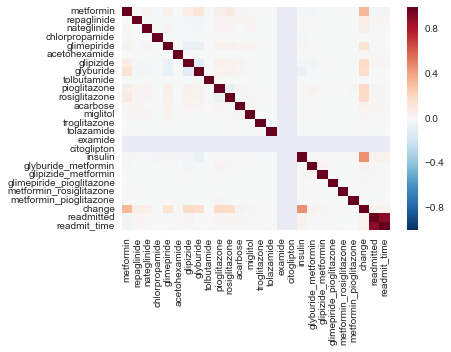

In [53]:
sns.heatmap(meds.corr())

apparently no patients on examide or citoglipton

# MACHINE LEARNING FOR PREDICTION & CLASSIFICATION

## MEDS

In [ ]:
X = meds.drop
y = meds[['readmitted', 'readmit_time']]

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.grid_search import GridSearchCV

logreg = LogisticRegression()
cross_val_score(logreg, X, y, cv=10, scoring='accuracy').mean()

In [ ]:
knn = KNeighborsClassifier(5)
cross_val_score(knn, X, y, cv=10, scoring='accuracy').mean()

In [ ]:
knn = KNeighborsClassifier()
param_grid = {'n_neighbors': range(1, 29, 2)}
grid = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')
grid.fit(X, y)

In [ ]:
grid_mean_scores = [result[1] for result in grid.grid_scores_]
plt.figure()
plt.plot(range(1, 29, 2), grid_mean_scores)

In [ ]:
from sklearn import metrics
preds = grid.best_estimator_.predict(X)
print metrics.confusion_matrix(y, preds)